<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/Custom_kernel_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [10]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [17]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)
  return score

In [18]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=20)

  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
          -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25))) - np.pi * 0.5 * np.log(2*np.pi)
  return log_mll

In [19]:
v1 = np.linspace(0.5,1.5,101)
l1 = np.linspace(0.5,1.5,101)
v2 = np.linspace(0.5,1.5,101)
l2 = np.linspace(0.5,1.5,101)

In [20]:
score_rf=[]
v1_list=[]
l1_list=[]
v2_list=[]
l2_list=[]

for i in range(30):
  v1_=random.choice(v1)
  v1_list.append(v1_)
  l1_=random.choice(l1)
  l1_list.append(l1_)
  v2_=random.choice(v2)
  v2_list.append(v2_)
  l2_=random.choice(l2)
  l2_list.append(l2_)

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3
  mll = BO(rf_score,kernel)
  score_rf.append(mll)

  print("v1 =", v1_, "l1 =", l1_, "v2 =", v2_, "l2 =", l2_, "mll =", mll)

v1 = 1.27 l1 = 1.3900000000000001 v2 = 1.44 l2 = 0.8200000000000001 mll = [[11.64043728]]
v1 = 0.87 l1 = 0.62 v2 = 0.6799999999999999 l2 = 1.3399999999999999 mll = [[3.54728323]]
v1 = 0.62 l1 = 1.4500000000000002 v2 = 0.73 l2 = 1.23 mll = [[3.02665051]]
v1 = 1.1 l1 = 1.0 v2 = 1.21 l2 = 0.6 mll = [[10.97874664]]
v1 = 1.27 l1 = 0.98 v2 = 1.21 l2 = 0.78 mll = [[19.38325669]]
v1 = 1.38 l1 = 1.03 v2 = 0.55 l2 = 1.06 mll = [[55.79627004]]
v1 = 1.27 l1 = 0.87 v2 = 1.02 l2 = 1.06 mll = [[32.7634212]]
v1 = 0.62 l1 = 1.19 v2 = 1.49 l2 = 1.03 mll = [[14.2548648]]
v1 = 0.59 l1 = 1.26 v2 = 1.0 l2 = 1.44 mll = [[2.53304514]]
v1 = 0.55 l1 = 0.81 v2 = 0.61 l2 = 0.55 mll = [[5.47411696]]
v1 = 1.22 l1 = 0.67 v2 = 0.96 l2 = 1.47 mll = [[45.72970394]]
v1 = 1.35 l1 = 0.54 v2 = 1.1 l2 = 0.64 mll = [[38.98716722]]
v1 = 0.6799999999999999 l1 = 0.88 v2 = 0.8400000000000001 l2 = 0.8 mll = [[2.37304338]]
v1 = 1.47 l1 = 1.13 v2 = 0.79 l2 = 0.86 mll = [[-4.05377273]]
v1 = 0.71 l1 = 0.97 v2 = 1.35 l2 = 0.61 mll = [

-0.9834641873278237
[  5.         149.66591954]


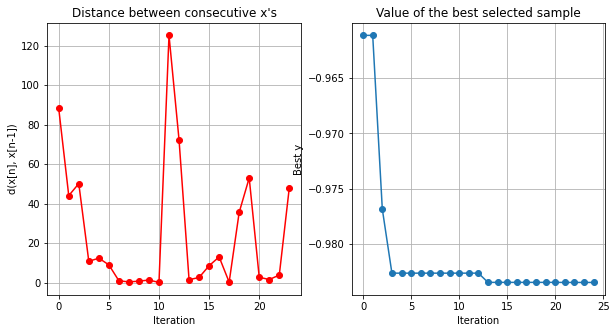

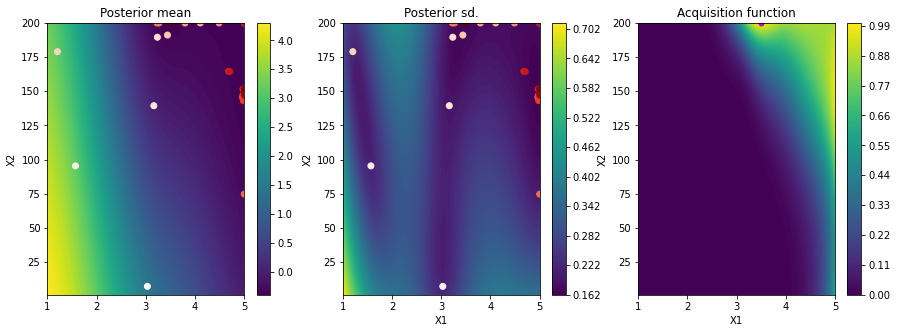

In [12]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=v1,lengthscale=l1,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=v2,lengthscale=l2,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=v1,lengthscale=l1,active_dims=[0]) \
         * GPy.kern.Matern52(input_dim=1,variance=v2,lengthscale=l2,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3
BO(rf_score,kernel)

In [ ]:
#RF Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9834573002754821
[  5.         169.68732109]


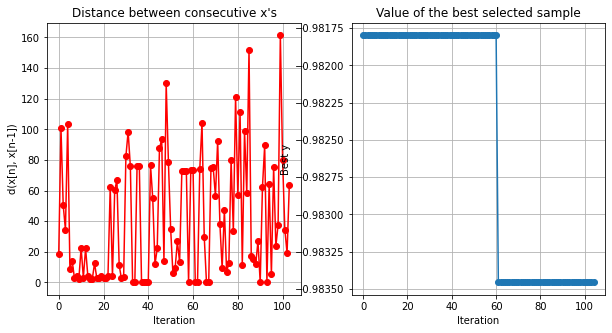

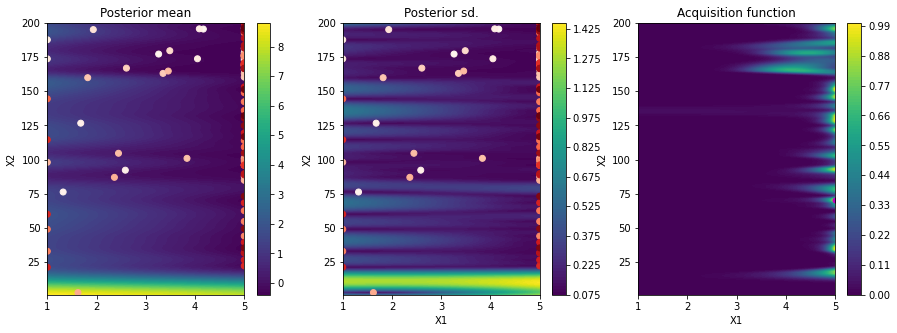

In [ ]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [ ]:
rf_car = RandomForestClassifier(max_features=5,n_estimators=169)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9672447013487476


In [ ]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.001, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

In [ ]:
#SVM Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

-0.9900757575757577
[67.85504824  0.228965  ]


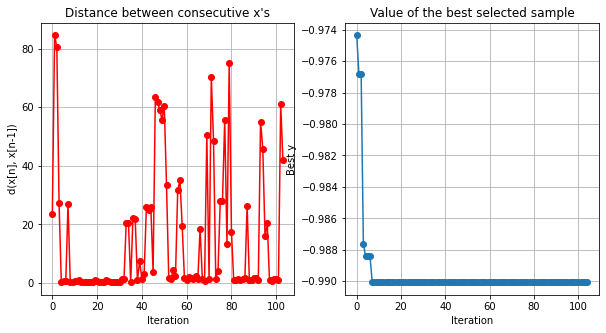

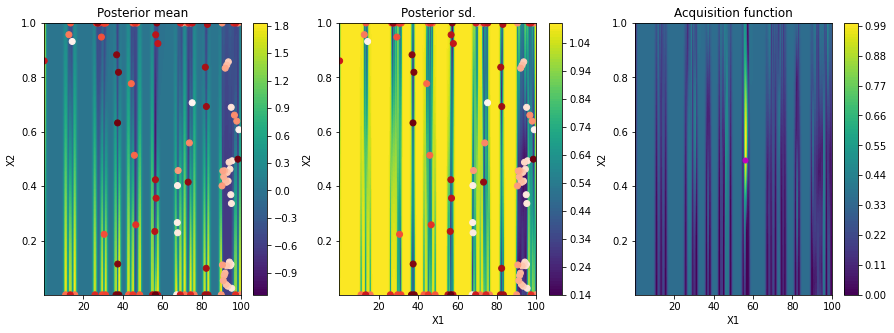

In [ ]:
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [ ]:
SVM_car1 = svm.SVC(C=67.85504824,gamma=0.228965)
SVM_car1.fit(X_train,y_train)
y_pred = SVM_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9865125240847784


In [ ]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)

  return score

-0.9082231404958676
[97.62853508  7.        ]


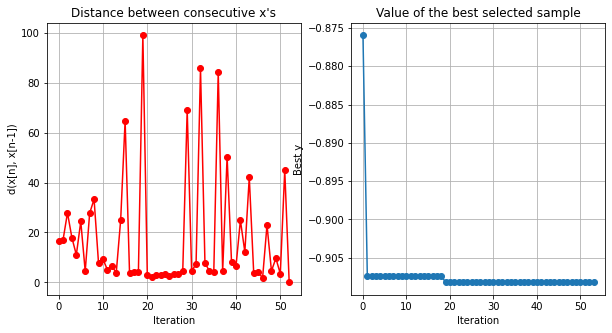

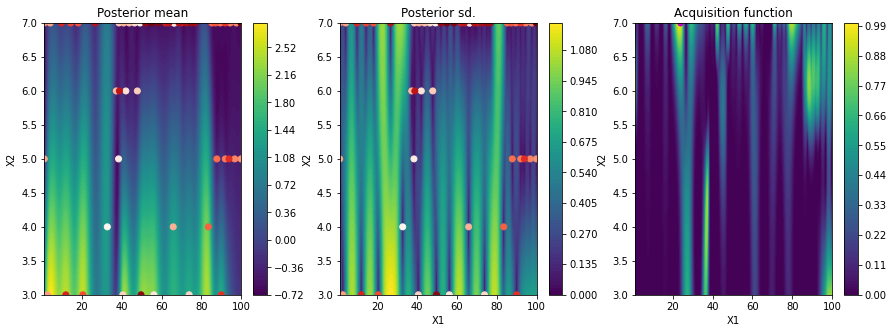

In [ ]:
#KNN Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=2, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=100)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()
optimizer.plot_acquisition()

In [ ]:
KNN_car1 = KNeighborsClassifier(leaf_size=97,n_neighbors=7)
KNN_car1.fit(X_train,y_train)
y_pred = KNN_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9267822736030829
